We'll do the same process in the tutorial, but with the hubble image.

In [63]:
import numpy as np
import sep

In [64]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits


%matplotlib inline
rcParams['figure.figsize'] = [10.,8.]

We'll read an example image from a FITS file and display it, as well as save it.

In [65]:
fart = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
data = fart[0].data
data = data.byteswap().newbyteorder()

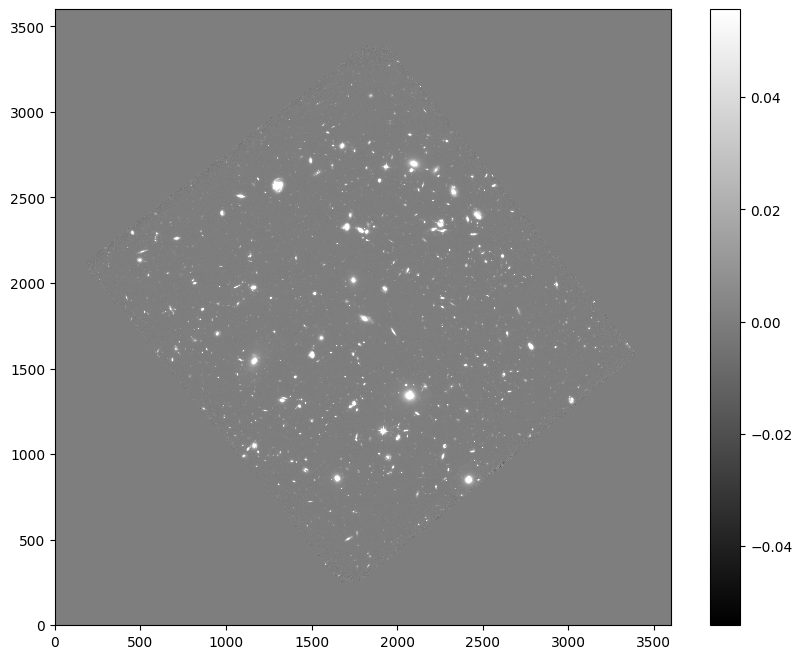

In [66]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig('HUBBLE1.png', bbox_inches='tight', dpi=600)

Background Subtraction for Hubble

In [67]:
bkg = sep.Background(data)

In [68]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [69]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

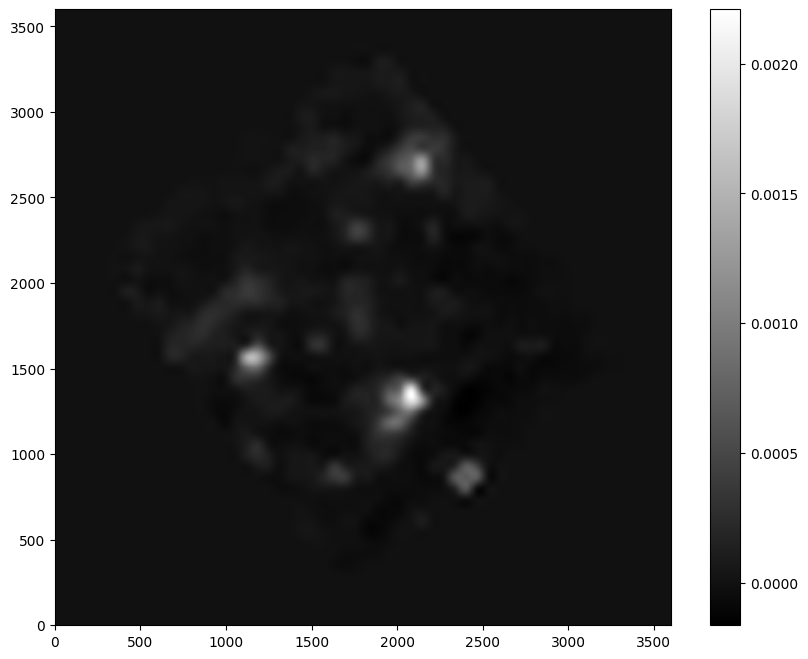

In [70]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('HUBBLE2.png', bbox_inches='tight', dpi=600)

In [71]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

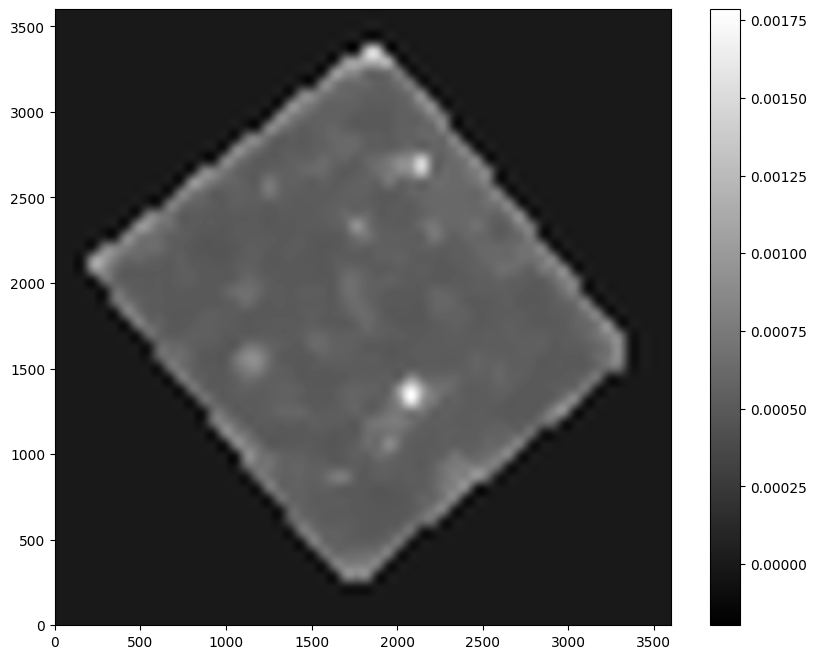

In [72]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig('HUBBLE3.png', bbox_inches='tight', dpi=600)

In [73]:
# subtract the background
data_sub = data - bkg

Object Detection

In [74]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [75]:
# how many objects were detected
len(objects)

8638

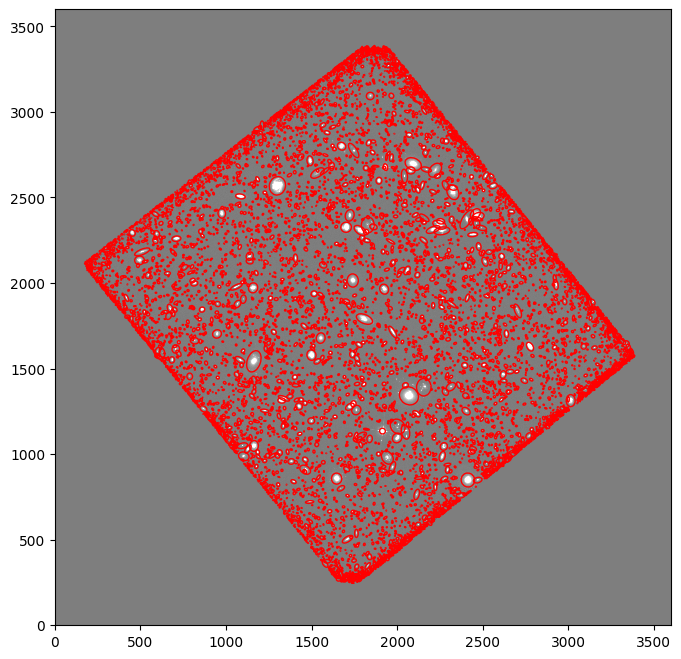

In [76]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('HUBBLE4.png', bbox_inches='tight', dpi=600)

In [77]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [78]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [79]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


There are 8640 sources detected

8638


(array([8.635e+03, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ -1.06136543,  79.77449947, 160.61036437, 241.44622927,
        322.28209417, 403.11795907, 483.95382397, 564.78968887,
        645.62555377, 726.46141867, 807.29728357]),
 <BarContainer object of 10 artists>)

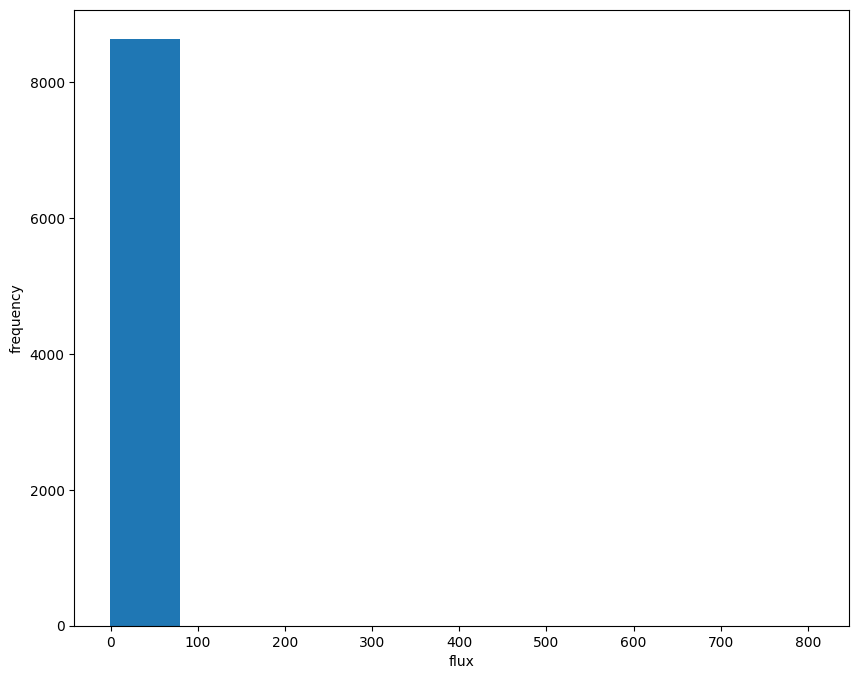

In [80]:
plt.xlabel('flux')
plt.ylabel('frequency')
print(len(objects))
plt.hist(flux)

Now we'll grab the mean, median, and standard deviation of the distribution of fluxes

In [81]:
mean = np.mean(flux)
median = np.median(flux)
deviation = np.std(flux)
print("Mean of flux:" , mean)
print("Median of flux:", median)
print("Standard deviation of flux:", deviation)

Mean of flux: 0.3619352265305736
Median of flux: 0.030969079434980812
Standard deviation of flux: 9.244596659828042


Now let's grab the largest outlier, position of the outlier, and how many deviations it lies from the mean.

In [82]:
outlier = np.argmax(np.abs(flux - mean))
print("Largest Outlier:", flux[outlier])
print("Outlier Position:", (objects['x'][outlier], objects['y'][outlier]))
print("Deviations from the mean:", ((flux[outlier] - mean) / deviation))

Largest Outlier: 807.2972835731507
Outlier Position: (1914.2549094883857, 1134.3164850742164)
Deviations from the mean: 87.28724227127394


Now lets get the other hubble images and make a 3 color false image.

In [83]:
fart1 = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
fart2 = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')

fartdata = data
fartdata1 = fart1[0].data
fartdata2 = fart2[0].data

In [84]:
rgb_values = []
for r in range(len(fartdata)):
    rgb_row = []
    for c in range(len(fartdata[r])):
        rgb_row.append((fartdata2[r][c], fartdata1[r][c], fartdata[r][c]))
    rgb_values.append(rgb_row)
rgb_values = np.array(rgb_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


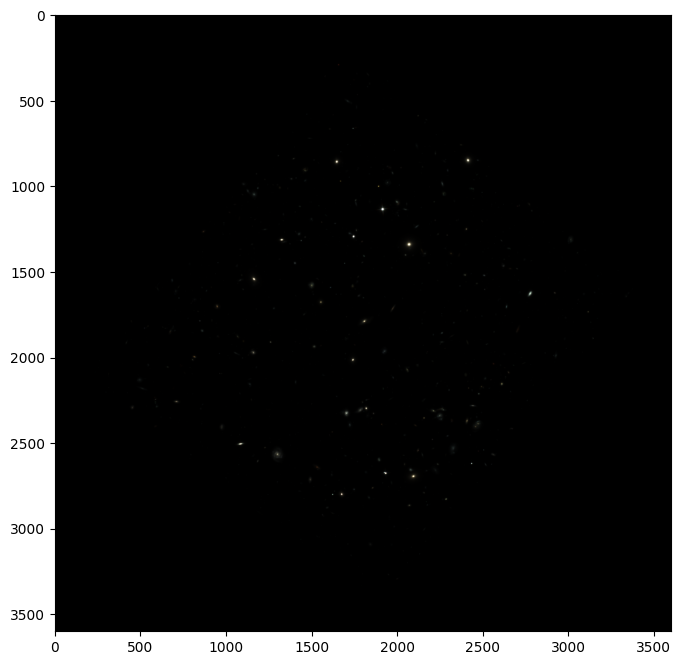

In [85]:
plt.imshow(rgb_values)
plt.savefig('HUBBLEFALSE.png', bbox_inches='tight', dpi=600)